### Step 1. Open the data file and study the general information. 

In [1]:
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import datetime
from scipy import stats as st
import scipy.stats as stats
from scipy.stats import mannwhitneyu


In [2]:
try:
    games=pd.read_csv('datasets/games.csv')
except:
    games=pd.read_csv('/datasets/games.csv')

spreadsheet_id = '1TBHt-KiKf8QQ_E0YaYxP3uJ_dAWy11b5wUeJF1Z1HaY'
file_name = 'https://docs.google.com/spreadsheets/d/1TBHt-KiKf8QQ_E0YaYxP3uJ_dAWy11b5wUeJF1Z1HaY/edit?usp=sharing'
r = requests.get(file_name)
col_names = ['unname',"name", "esrb_rating", "metacritic"]
game_info_new=pd.read_csv(file_name, names=col_names, header=None, encoding='utf-8')
game_info_new=game_info_new.drop(columns=['unname'])

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


The data is about the online games, the main purpose of the task is to find the most profitable platforms in the market, to find the correlation between sales and rating by a different source. 


### Step 2. Prepare the data 

In [4]:
games['Name']=games['Name'].str.lower()
games['Platform']=games['Platform'].str.lower()
games['Genre']=games['Genre'].str.lower()
games.columns = map(str.lower, games.columns)

In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB



We see that there some data formats that have been changed to right format such as : Year_of_Release and User_Score

In [6]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

There are some missing values and tbd values in User_score, therefore I cannot convert it into int format. I think that there are no big differences between nan and tbd values because in any case, we do not have data in our hand , the reason would anything but the important thing is that they are not here. Therefore, I convert tbd to nan values. 

In [7]:
games['year_of_release']=pd.to_datetime(games['year_of_release'], format='%Y')
games['user_score'].replace("tbd", np.nan, inplace=True)
games['user_score'] = pd.array(games['user_score'], dtype="float64")
games['year_of_release'] = pd.to_datetime(games['year_of_release'])
games['year_of_release'] = games['year_of_release'].dt.year

I replaced the 'tbd' with Nan values, and  the type of User_Score  to Float64. 

In [8]:
games.isna().mean().round(4)*100

name                0.01
platform            0.00
year_of_release     1.61
genre               0.01
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
critic_score       51.32
user_score         54.59
rating             40.48
dtype: float64

The problem is that there is a lot of missing value, the reason could be that may be that player just did not like to play the game, and they did want to spend the time rating it. I tried a lot why to fill the missing values, but in every method, there are some problems: First I thought that may be the missing values are the games that the player did not like at all, in order to find this information I looked at the sales if sales total sells are 0, it means that no one bought, high probably there were not good games or there was some problem, therefore filling these values with Zero (0) , I think will not hurt, but these values are just 2. I think that the most command reasons for missing values in critic_score and user_score and rating first , may be the games are not so popular or not so good , therefore , people just ignored them, the second is that may be they are not make their decitions about games.

In [9]:
games['sales_total']=games['eu_sales']+games['jp_sales']+games['other_sales']+games['na_sales']

In [10]:
cond = games['sales_total'] ==0
games['critic_score'].fillna(cond.map({True:0, False :np.nan}),inplace=True)
games['user_score'].fillna(cond.map({True:0, False :np.nan}),inplace=True)
games['rating'].fillna(cond.map({True:'E',False :np.nan}),inplace=True)

In [11]:
games.isna().mean().round(4)*100

name                0.01
platform            0.00
year_of_release     1.61
genre               0.01
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
critic_score       51.31
user_score         54.58
rating             40.47
sales_total         0.00
dtype: float64

The second method that I wanted to fill the missing values with Names. I mean I check if there are duplicated Name( the same names) in the data, then finding the mean of these same names , then fill it with the mean of them. But again the problem is that Platform , year of Release, Genre  are different even if the names are the same, and it makes quite a dangerous filling missing values with the mean of them: Because the game in for example ps2 platform is good but ps3 platform is not satisfactory. Also for example maybe the game is quite a good 2006 version but it is not a successful 2008 version. These things made the filling missing values quite dangerous, because the result could be wrong . Beacuse of these reasons I will not use these method ,but I tried these method to see how much I can eleminate the missing value : I get about 10% reduction in missing values in  Critic_Score(39.96)  and User_Score(42.47). 

The third method I thought that I can group the total sell column in order to find which games are sold a lot and  which games are not sold, Then  using this information I can fill the missing values, but again we have a problem :  There are a lot of games are sold just 0.1 million but they got better Critic_Score and User _Score score than that were sold about 30 milling.Also, the games which were sold just 0.1 million different a lot  in terms of Critic Score,  User_Score, and Rating.Therefore , I do not filling the mising values by group  the games according to the amount of sells.

In [12]:
games[games['sales_total']==0.1].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
10054,phantom dust,xb,2004.0,action,0.08,0.02,0.00,0.00,81.0,8.5,T,0.1
10070,stubbs the zombie in rebel without a pulse,xb,2005.0,action,0.08,0.02,0.00,0.00,75.0,8.1,M,0.1
10071,batman: dark tomorrow,xb,2003.0,action,0.08,0.02,0.00,0.00,25.0,3.6,T,0.1
10084,batman: rise of sin tzu,xb,2003.0,action,0.08,0.02,0.00,0.00,67.0,7.7,T,0.1
10091,spy vs spy,xb,2005.0,action,0.08,0.02,0.00,0.00,53.0,8.0,T,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
11081,skylanders imaginators,x360,2016.0,platform,0.04,0.05,0.00,0.01,NaN,NaN,E10+,0.1
11124,pipe mania,ds,2008.0,puzzle,0.08,0.01,0.00,0.01,71.0,NaN,E,0.1
11125,dora's big birthday adventure,ds,2010.0,misc,0.08,0.01,0.00,0.01,NaN,NaN,E,0.1
11154,challenge me: brain puzzles 2,ds,2010.0,puzzle,0.05,0.04,0.00,0.01,NaN,NaN,E,0.1


The last thing, I thought I can do  that is to look at the correlation in order to fill in the missing values: For example, if Critic_Score and User_Score are strongly correlated that, I can use this correlation to fill the missing values, But again there is no strong correlation that I can use to fill the missing values. We can also there look at the correlation among   total sales, Critic_Score and  User_Score. Again the correlation is very weak. In conclusion, there is no correlation between User_score and Critic Score also, we do not see it between total sales and scores. Therefore, It is better do not to fill any missing value.

In [13]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = games.corr()
corr.style.background_gradient(cmap='coolwarm')

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,sales_total
year_of_release,1,-0.0925004,0.00397783,-0.168366,0.0378202,0.0111375,-0.267137,-0.076313
na_sales,-0.0925004,1,0.765335,0.449594,0.638649,0.240507,0.0864494,0.941017
eu_sales,0.00397783,0.765335,1,0.435061,0.722792,0.220485,0.0555984,0.90124
jp_sales,-0.168366,0.449594,0.435061,1,0.291089,0.152387,0.125495,0.612289
other_sales,0.0378202,0.638649,0.722792,0.291089,1,0.198309,0.0573324,0.74926
critic_score,0.0111375,0.240507,0.220485,0.152387,0.198309,1,0.583868,0.245227
user_score,-0.267137,0.0864494,0.0555984,0.125495,0.0573324,0.583868,1,0.0884081
sales_total,-0.076313,0.941017,0.90124,0.612289,0.74926,0.245227,0.0884081,1


In [14]:
game_info_new['name']=game_info_new['name'].str.lower()

In [15]:
games_new= games.merge(game_info_new, on="name", how="left")

In [16]:
games_new['critic_score'].fillna(value=games_new["metacritic"], inplace=True)
games_new['rating'].fillna(value=games_new["esrb_rating"], inplace=True)

In [17]:
games_new.drop(columns=['esrb_rating', 'metacritic'], inplace=True)

In [18]:
games_new.isna().sum().sum()

26396

In [19]:
games.isna().sum().sum()

24736

I also use data form "kaggle.com" to fill the missing values .  I managed to fill some missing values but they are not many . 

I tried some ways to fill the missing values, I managed some of them, But I think  that it is better to leave some of them also as missing values because of their characteristics .

### Step 3. Analyze the data

In [20]:
games_new.groupby('year_of_release')['name'].count().sort_values(ascending=False).head(10)

year_of_release
2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
Name: name, dtype: int64

Now we can see that how many games were released each year. The max number is 1427 in 2008. Data in every period is not significant, because there are sometimes increases or decreases as the years by year. But I would say in we consider decade, I can say that yes, data is significant because every 10 years, there is a significant increase in the number of games.

In [21]:
platform=games_new.pivot_table(index='platform', values='sales_total', aggfunc='sum').sort_values('sales_total', ascending='False')

Text(0, 0.5, 'Total amount of sales')

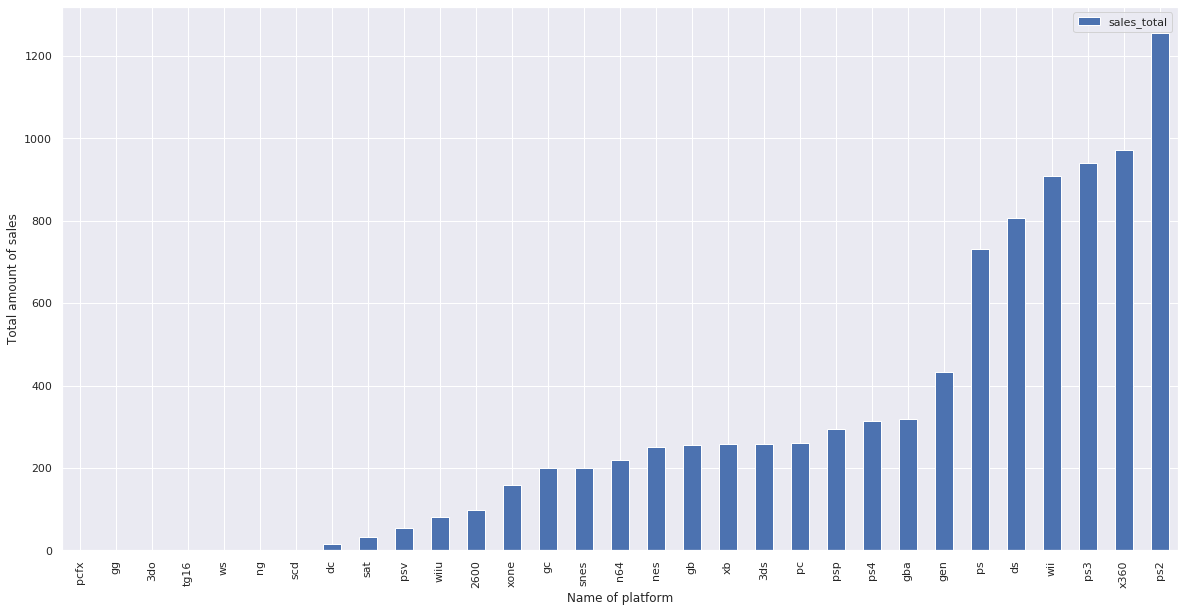

In [22]:
platform.plot(kind='bar', grid=True, figsize=(20,10)) 
plt.xlabel('Name of platform')
plt.ylabel('Total amount of sales')

In this graph we can see the how the sales are varies from  platform to platform . The most  sold pralform are ps , ds , wii , ps 3 , x360 and with the greatest sales ps 2 . More excatly,  ps2 platform and x360 platforms  have the greates total sales with 1255.77 and 971.41 ( billions )

In [23]:
platform_greatest=games_new.pivot_table(index=['year_of_release'], values='sales_total', aggfunc='sum')
platform_greatest=platform_greatest[platform_greatest['sales_total']>600]

I chose the platform that sold more than 600 (billion) because We can see that  the most profitable platform ( which I mentioned their names in the previous task ) were sold more than 600 ( billion ) 

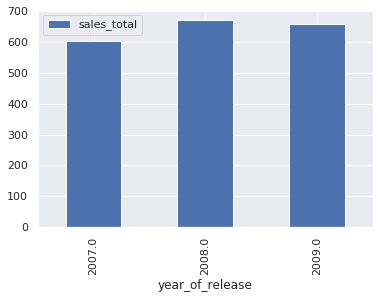

In [24]:
platform_greatest.plot(kind='bar', grid=True) 

In this graph, I tried to show that how sales are different year by year in the most sold platforms, we can see that 2007 is the start year for platforms to be popular and 2008 was the most profitable year for platforms.

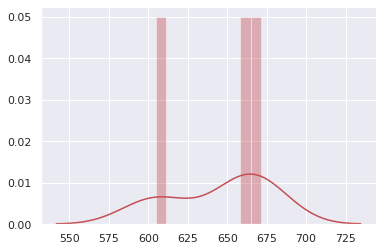

In [25]:
fig, ax = plt.subplots()
sns.distplot(platform_greatest, bins=10, color="r", ax=ax)
plt.show()

I created also despot because I didn't understand the question exactly what it means 'build a distribution based on data for each year ' may you also would like this graph.

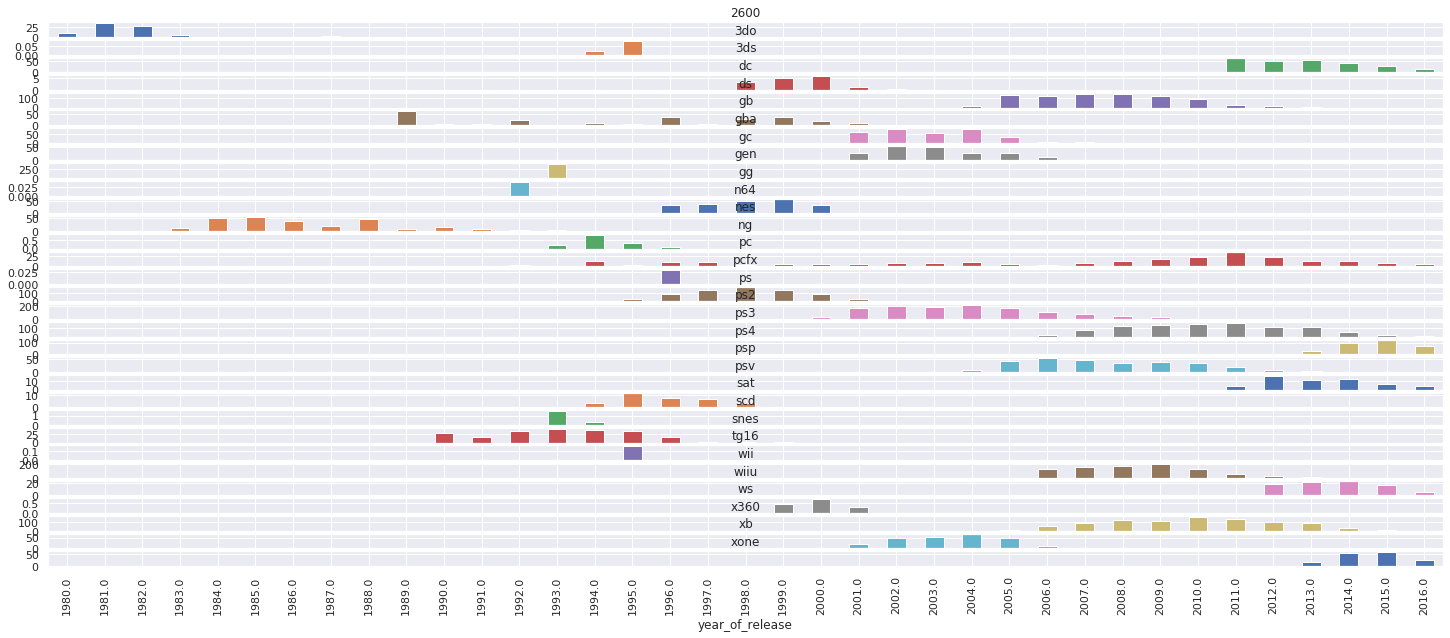

In [26]:
year_distibution=games_new.pivot_table(index='year_of_release', values='sales_total', columns='platform',aggfunc='sum')
year_distibution.plot.bar(stacked=True, figsize=(25,10), subplots=True, mark_right=False, legend=False)
plt.show()

I tried in this graph to find an answer to 'Find platforms that used to be popular but now have zero sales'. But I think that I am not so much success because of having a lot of columns, the graph seems to be confusing. But I think we can say which platform was popular and even in which years they reached their max profit. For example, 2600 was very popular until 1982 and actually was the only platform in the market but today they are not any more existed, We can say the same thing in the different time periods for 3do , dc , ds, gb, gb and so on . I find   this graph quite practical to find the question of 'How long does it generally take for new platforms to appear and old ones to fade?',  beacuse  it very easy to calculate  it . I think that it takes something between 12 year and 6 years one platfom to appear  and disapper. 

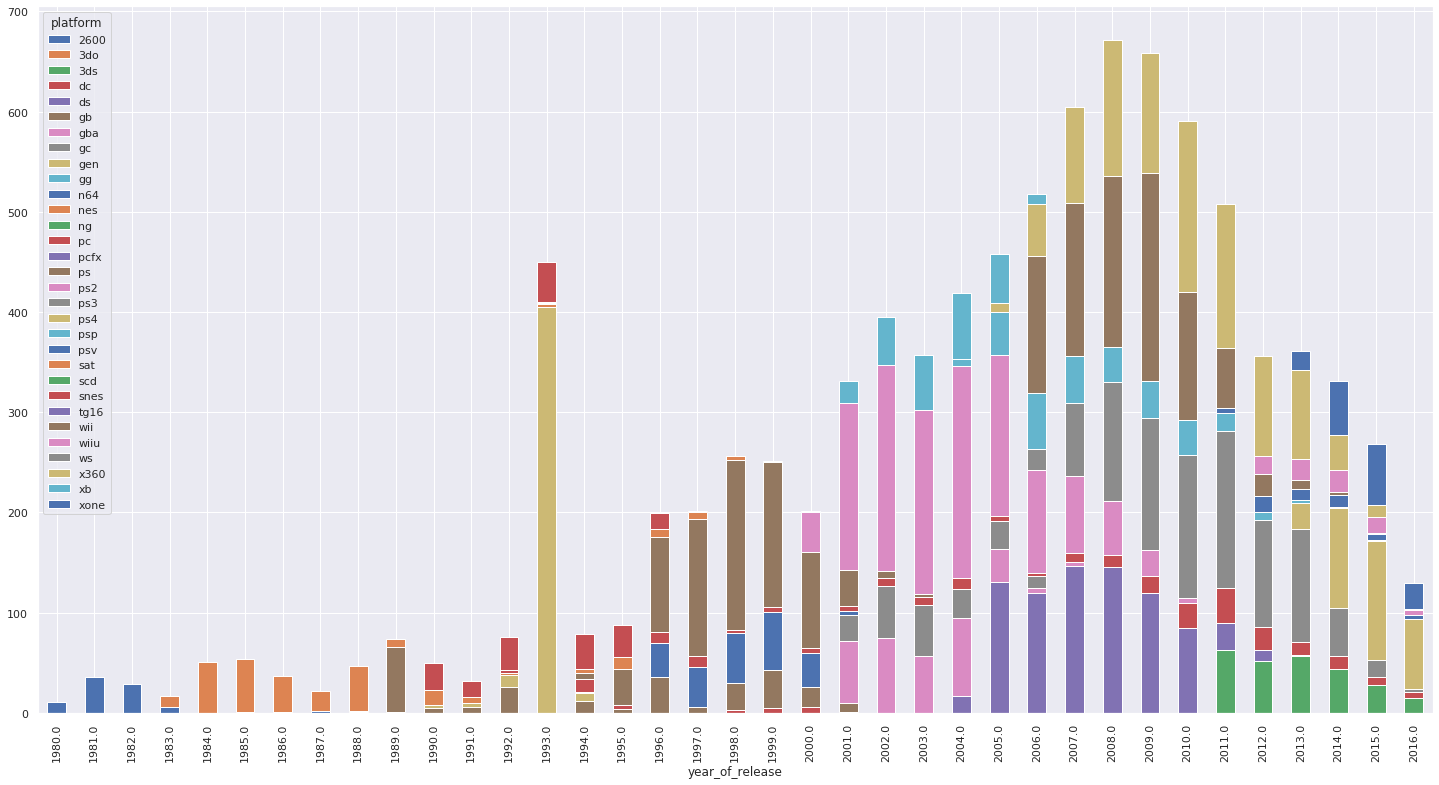

In [27]:
year_distibution.plot.bar(stacked=True, figsize=(25,13))
plt.show()

I was not so much happy with the graph above , therefore I decided to group the years as much as small group to have not so much platform then it could be easier to see the name of platform which were popular but they are not exited any more . I think that I can use this graph to separate the years to period and plot the graph again. First period( 1980-1987)( because the sales were overall not so much during this period and there were not so much compny in the market ), second ( 1988-1995) ( because the sales were overall not so much during this period but the name of complanies increased  ) ,third period(1996-2008) ( because there was  boom in the market) ,  fourth period ( 2009-2013)  and fiveth ( 2014 -2016)  perido beacuse the companies entered the market and the overall path was more table , there for we can use this path to predict the future. 

Text(0.5, 1.0, 'Form 2014 to 2016 the platfrom in the market')

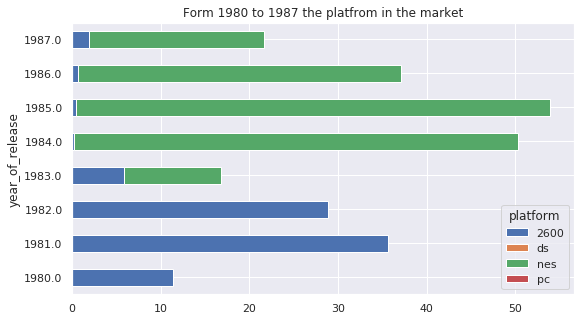

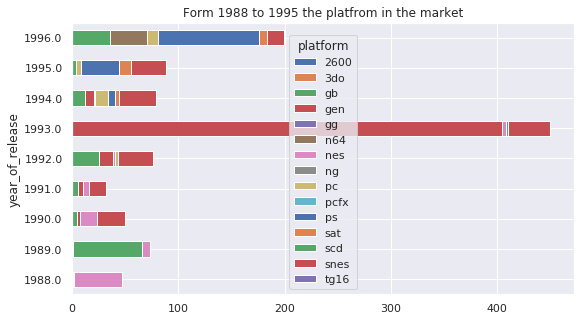

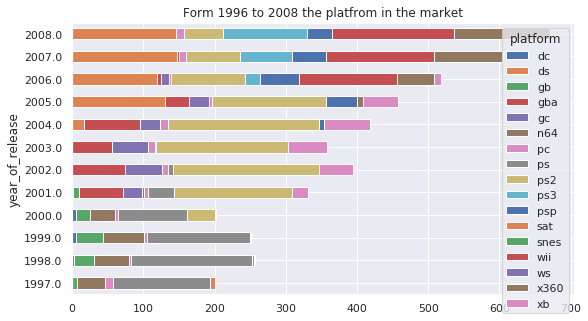

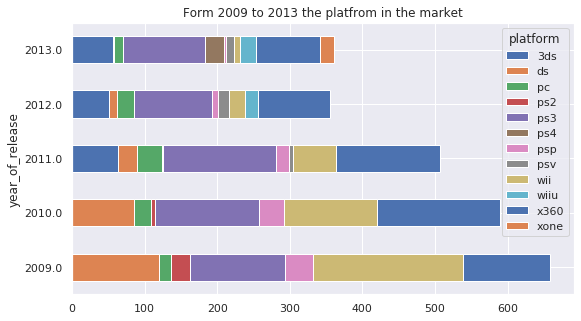

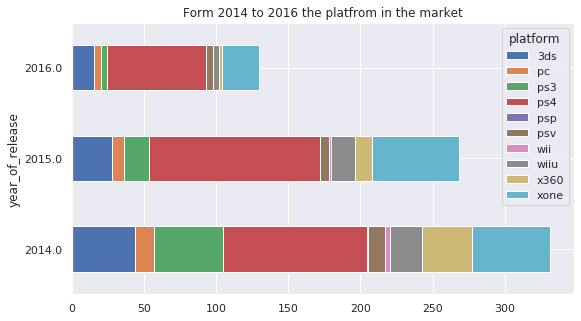

In [28]:
first_period=games_new[games_new['year_of_release']<=1987]
first_period_pivot=first_period.pivot_table(index='year_of_release', values='sales_total', columns='platform',aggfunc='sum')

second_period=games_new.query('1987<year_of_release<=1996')
second_period_pivot=second_period.pivot_table(index='year_of_release', values='sales_total', columns='platform',aggfunc='sum')

third_period=games_new.query('1996<year_of_release<=2008')
third_period_pivot=third_period.pivot_table(index='year_of_release', values='sales_total', columns='platform',aggfunc='sum')

fourth_period=games_new.query('2008<year_of_release<=2013')
fourth_period_pivot=fourth_period.pivot_table(index='year_of_release', values='sales_total', columns='platform',aggfunc='sum')

fiveth_period=games_new.query('2013<year_of_release<=2016')
fiveth_period_pivot=fiveth_period.pivot_table(index='year_of_release', values='sales_total', columns='platform',aggfunc='sum')

first_period_pivot.plot.barh(stacked=True, figsize=(9, 5))
plt.title("Form 1980 to 1987 the platfrom in the market")

second_period_pivot.plot.barh(stacked=True,  figsize=(9, 5))
plt.title("Form 1988 to 1995 the platfrom in the market")

third_period_pivot.plot.barh(stacked=True, figsize=(9, 5))
plt.title("Form 1996 to 2008 the platfrom in the market")

fourth_period_pivot.plot.barh(stacked=True, figsize=(9, 5))
plt.title("Form 2009 to 2013 the platfrom in the market")

fiveth_period_pivot.plot.barh(stacked=True, figsize=(9, 5))
plt.title("Form 2014 to 2016 the platfrom in the market")

I think that here is easier to see which platform used to be popular but now has zero sales, because we have to just look at the period of 2009 to 2016, to find which platform is existed and look at other periods to see whether they also before existed. Such as 2600, 3do, gg , ness and so on are not exist anymore. Interestingly ''pc' and 'ds' are in the market from 1987 until 2016.

Text(0.5, 0, 'Years')

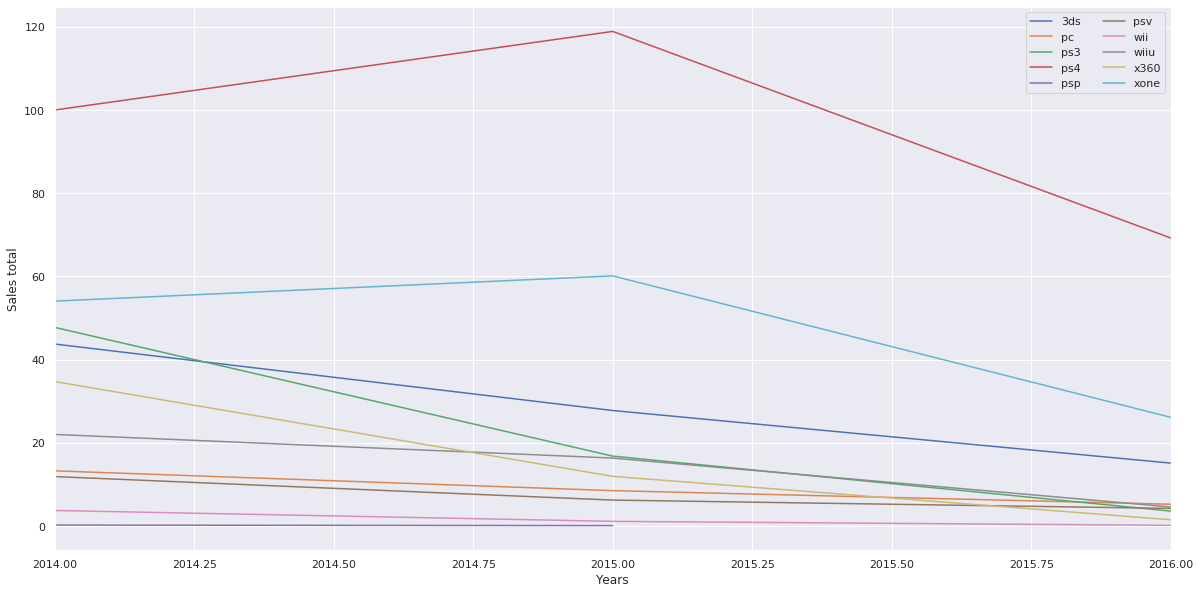

In [29]:
fiveth_period_pivot.plot(figsize=(20, 10));
plt.legend( ncol=2, loc='upper right' )
plt.ylabel('Sales total')
plt.xlabel('Years')

Thanks for your valuable comment, I  created an extra period( fifth perdio), I think the reasons why we have to choose data since 2014, firth new firms enter in the market, which could influence the market sales significantly,  second since 2014 the market has a more stable path which makes the prediction more realistic, Third reason is that because of a constantly growing market, it is better to take a short time period. I hope that these 3 reasons are correct. I would like very happy to know also your explanation about it.


In [30]:
fiveth_period.groupby('platform')['sales_total'].sum().sort_values(ascending=False)

platform
ps4     288.15
xone    140.36
3ds      86.68
ps3      68.18
x360     48.22
wiiu     42.98
pc       27.05
psv      22.40
wii       5.07
psp       0.36
Name: sales_total, dtype: float64

We can see from the graph that xone and ps3 and x360 are leading.Generally,  there is a  decrease in sales during this period,  PSP disappeared from the market in 2015, and wii try just to survive. It better to see it also in numeric  format .

In [63]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

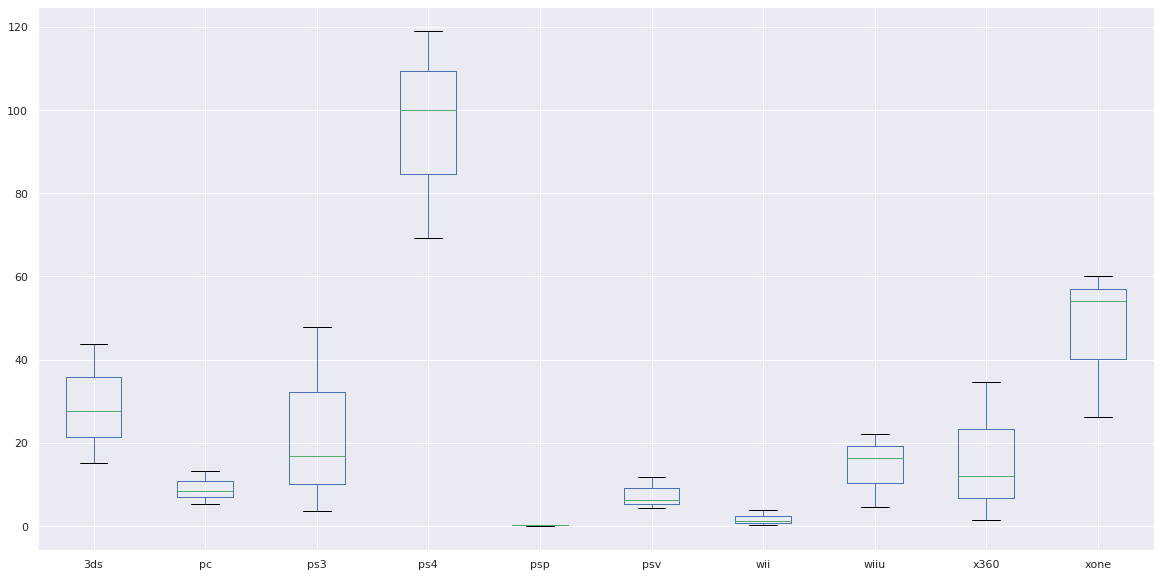

In [64]:
fiveth_period_pivot.boxplot(figsize=(20, 10))

Yes, It seems that differences sales in platform are significant. if you look at the Q1 and Q3 ( their intervals) values, Ps3 , ps4  and X360 prices changed significantly over time, I think is because of their price strategy but pc , wii  , psp, psv  Q1 and Q3 value are not different from each other , it means that since 2014 they were sold overall at the same price. ps4  has the average greatest value in the market  and psv   have the smallest sales in the market 

In [32]:
ps4_platform=fiveth_period.query('platform=="ps4"')

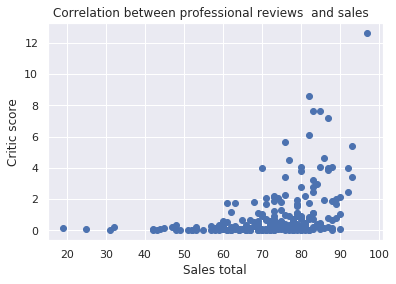

In [33]:
plt.scatter(ps4_platform['critic_score'], ps4_platform['sales_total']) # 'b' is the color blue
plt.xlabel('Sales total')
plt.ylabel('Critic score')
plt.title("Correlation between professional reviews  and sales  ")
plt.show()

In [34]:
print(ps4_platform['critic_score'].corr(ps4_platform['sales_total']))

0.402661410681041


From the graph and correlation value, we see that the correlation between sales and critic_score is weak, There is only a postive  correlation when the price is very high at that  time the critic scores are also high in ps4_platform ) 

In [35]:
print(games_new['critic_score'].corr(games_new['sales_total']))

0.24522663466125222


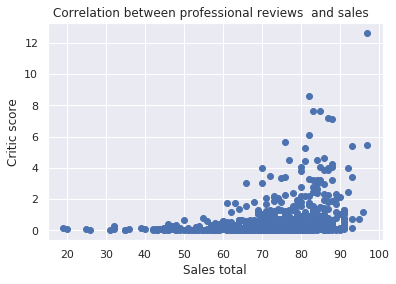

In [36]:
plt.scatter(fiveth_period['critic_score'], fiveth_period['sales_total']) 
plt.xlabel('Sales total')
plt.ylabel('Critic score')
plt.title("Correlation between professional reviews  and sales  ")
plt.show()

This time I looked at the general correlation between sales and reviews on all platforms. The correlation is very weak, So we can come to the conclusion that the critic score does not play a key role in the price of the platform. The companies should not take the critics' thoughts about their platform because no one listens to them

In [37]:
x360_platform=fiveth_period.query('platform=="x360"')
ds_platform=fiveth_period.query('platform=="3ds"')
ps3_platform=fiveth_period.query('platform=="ps3"')
xone_platform=fiveth_period.query('platform=="xone"')

In [38]:
print(x360_platform['critic_score'].corr(x360_platform['sales_total']))
print(ds_platform['critic_score'].corr(ds_platform['sales_total']))
print(ps3_platform['critic_score'].corr(ps3_platform['sales_total']))
print(xone_platform['critic_score'].corr(xone_platform['sales_total']))

0.5257228356581523
0.314117492869051
0.44657460493190715
0.42867694370333226


We see that the correlation in other platform also weak . 

In [39]:
genre_group=fiveth_period.groupby('genre')['name'].count().sort_values( ascending=False)

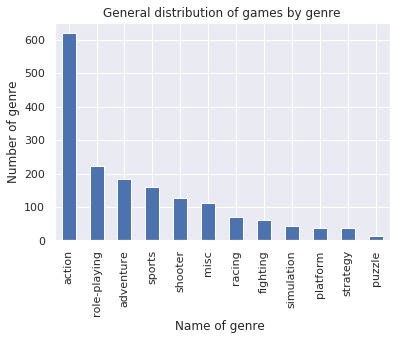

In [40]:
genre_group.plot(kind='bar', grid=True); 
plt.xlabel('Name of genre ')
plt.ylabel('Number of genre')
plt.title("General distribution of games by genre")
plt.show()

The most of games are from action genre and the number of puzzle games is the least.

Text(0.5, 0, 'Number of genre')

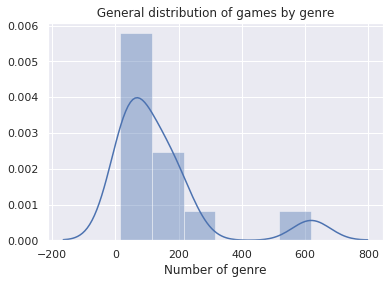

In [41]:
ax=sns.distplot(genre_group) 
ax.set_title(" General distribution of games by genre ")
ax.set_xlabel('Number of genre')

I  also used distplot to show the distribution of number of genre  because I was not sure what the question wants exactly  ;(Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales? . But this that this is the correct , from distibution we can say that number of genre are mainly between 0 and 100:
)

In [42]:
genre_sales=games_new.groupby('genre')['sales_total'].sum().sort_values( ascending=False)

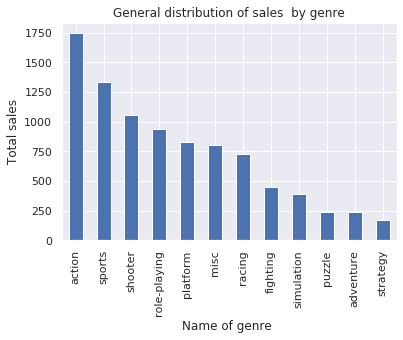

In [43]:
genre_sales.plot(kind='bar', grid=True) 
plt.title("General distribution of sales  by genre")
plt.xlabel('Name of genre ')
plt.ylabel('Total sales')
plt.show()

The most profitable genre is action and strategy is the least profitable. 

Text(0.5, 0, 'Amount of sales')

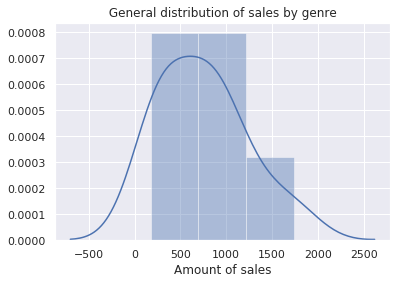

In [44]:
ab=sns.distplot(genre_sales) 
ab.set_title(" General distribution of sales by genre ")
ab.set_xlabel('Amount of sales')

For the same reason, I also use this graph, this  shows that the distribution of sales is the normal distribution and the most common prices are between 500 and 1000 :

The sales in the market started to increase from 2001( I think because of worldwide use of the internet and mass production of computers ) and it reached their highest point in 2008, after this period the sales started to decrease, I believe that this decrease also continue in 2017, the average price of platform different from each other significantly, and the market is occupied by ps2 , ps3 , x360 wii ds platforms. It seems that there is also no correlation between critic score and the sales of games. In general, in about 10 years, the platforms come to market and old ones disappear , in last decided, the sales decreasing however xone and ps4  platform managed to increase their sales from  2013 but it lasted just 2 years.  

### Step 4. Create a user profile for each region

In [45]:
top_platforms=games_new.pivot_table(index='platform', values=['sales_total', 'na_sales','eu_sales', 'jp_sales' ],aggfunc='sum').sort_values('sales_total', ascending=False)
top_five_platforms=top_platforms.head(5)

I have to say that the question seems to me a lot blur because The question says "For each region (NA, EU, JP), determine: The top five platforms' but in what in sales or in the number of games they produced. I chose the top five platform in sales.

In [46]:
top_five_platforms

,eu_sales,jp_sales,na_sales,sales_total
platform,,,,
ps2,339.29,139.20,583.84,1255.77
x360,270.76,12.43,602.47,971.42
ps3,330.29,80.19,393.49,939.65
wii,262.21,69.33,496.90,907.51
ds,188.89,175.57,382.40,806.12


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f874ed0ab10>,
      dtype=object)

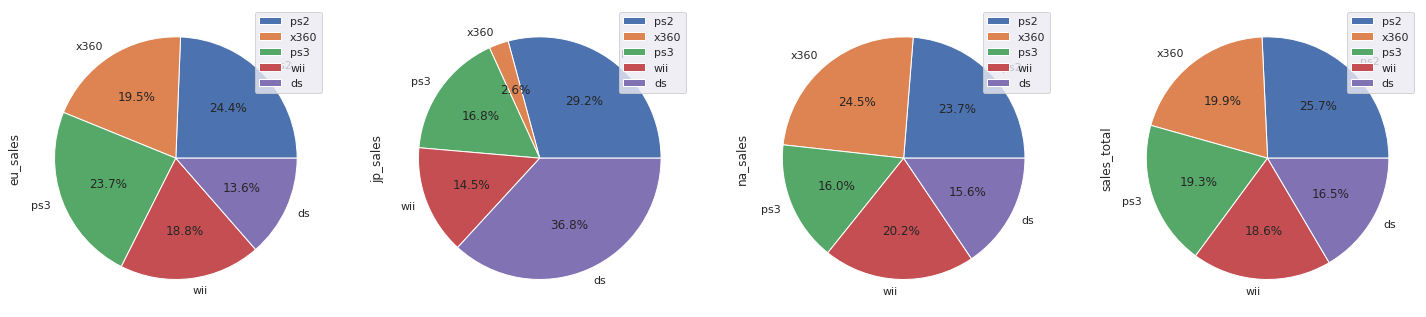

In [47]:
top_five_platforms.plot.pie(subplots=True, figsize=(25, 25), autopct='%1.1f%%')


From the table and from the pie chart, we can see how market share varies from region to region .ps is popular in North American and Europe, x360 differs in North American sales in sales,ps3 sales in Europe and North American are also high, , Wii and ds earn more profit North American compared to other regions.

In [48]:
top_genres=games_new.pivot_table(index='genre', values=['sales_total', 'na_sales','eu_sales', 'jp_sales' ],aggfunc='sum').sort_values('sales_total', ascending=False)
top_five_genres=top_genres.head(5)

In [49]:
top_five_genres

,eu_sales,jp_sales,na_sales,sales_total
genre,,,,
action,519.13,161.43,879.01,1744.17
sports,376.79,135.54,684.43,1331.27
shooter,317.34,38.76,592.24,1052.45
role-playing,188.71,355.41,330.81,934.56
platform,200.35,130.83,445.50,827.77


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f874dbdbe90>,
      dtype=object)

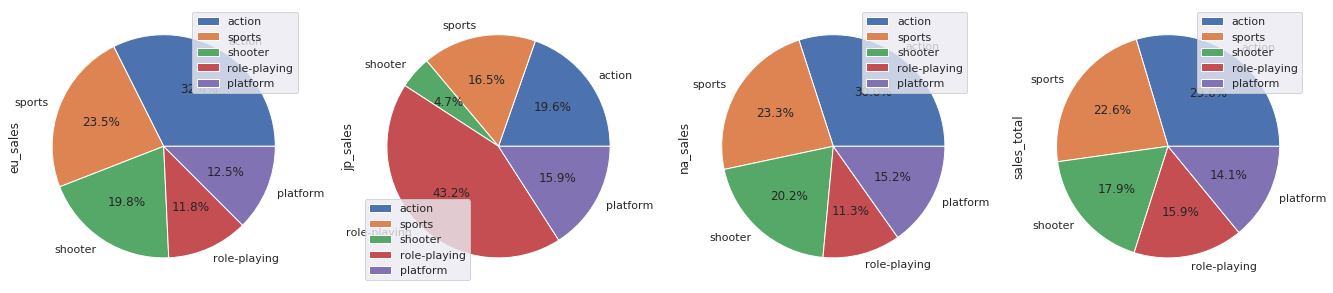

In [50]:
top_five_genres.plot.pie(subplots=True,figsize=(23, 23), autopct='%1.1f%%')

I can say that North American sales in the greatest in all genres, except role-playing, the second profitable market for all genres in Europe. But in Japan people prefer role paying as the second-best genre, however, Japan is the least profitable market for other genres

In [51]:
games_new['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [52]:
games_new['rating'].replace(['E10+', 'Everyone', 'Everyone 10+'], 'E', inplace=True)
games_new['rating'].replace('Teen', 'T', inplace=True)
games_new['rating'].replace('Mature', 'M', inplace=True)
games_new['rating'].replace('Adults Only', 'AO', inplace=True)
games_new['rating'].replace('Rating Pending', 'RP', inplace=True)

In [53]:
esrb=games_new.pivot_table(index='rating', values=['sales_total', 'na_sales','eu_sales', 'jp_sales', 'user_score' ],aggfunc='sum').sort_values('sales_total', ascending=False)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f874f0e0290>,
      dtype=object)

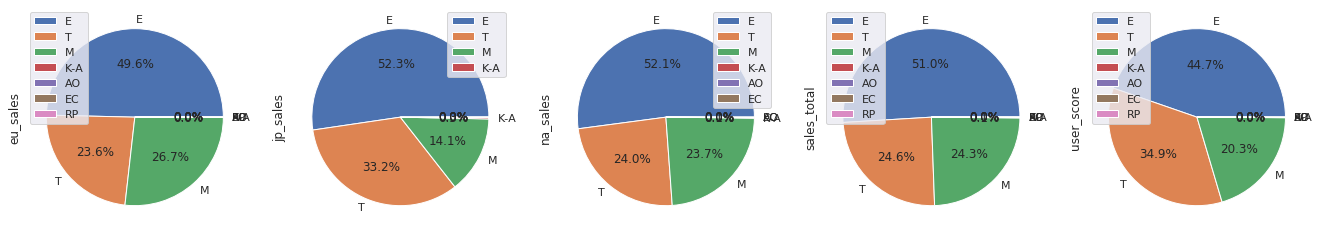

In [54]:
esrb.plot.pie(subplots=True,figsize=(23, 23), autopct='%1.1f%%')

It seems that ESRB affects the sales in the regions, because all-region almost have the same distribution, among E, T, M. But I think that it is very hard to say certainly that Yes, ESRB affects people choice, the reason is that may be people even do not look at the rating, just like the games which are rated as E, M, T by ESRB. I mean the maybe there is no correlation between people's choice and ESRB, just it coincides. Briefly, ESRB ratings affect sales individuals in regions, I think that with just this information, it is very hard to say.

In the third step, the main purpose is to analyze sales from platform to platform, from region to region, and to find out that the sales are affected by the critic scores.  We can a concussion that North American and Europe are the most profitable areas, for genres this tendency is also true for the 5  greatest platforms. ESRB rating affects the sales, I think it is not clear because of the direction of correlation. 

### Step 5. Test the following hypotheses:

In [55]:
xbox =games_new[games_new['platform'].str.contains("xb")]
ps =games_new[games_new['platform'].str.contains("ps")]


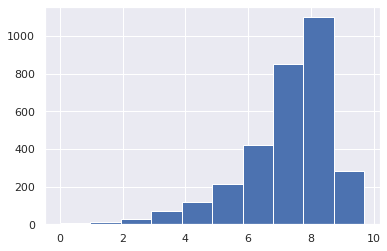

In [56]:
ps['user_score'].hist()

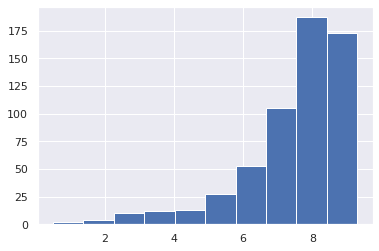

In [57]:
xbox['user_score'].hist()

The reason is that ps['user_score']  and xbox['user_score']  are  not distributed normall
that is why  we have to used Mann-Whitney.

In [58]:
stat, p = mannwhitneyu(xbox['user_score'], ps['user_score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print("We can't reject the null hypothesis")
else:
	print("We reject the null hypothesis")

Statistics=2168936.500, p=0.000
We reject the null hypothesis


The first hypothesis is that "Average user ratings of the Xbox One and PC platforms are the same."". I take H 0 as the  Average user ratings is the same in both platforms. H1 as Average user ratings of the Xbox One and PC platforms  differs. I order to find answers to these questions we have to look at the Average user ratings of both  find means, and the probability that both have the same value, if the p-value is less than 0.05 we reject H0 otherwise we will accept H0. The distribution of monthly income is nonparametric therefore, I used Mann Whitney U test. 

so, the result is that Average user ratings of the Xbox One and PC platforms are NOT  the same.

In [59]:
action  =games_new.query('genre=="action"')
sports  =games_new.query('genre=="sports"')

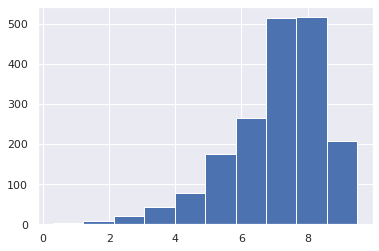

In [60]:
action['user_score'].hist()

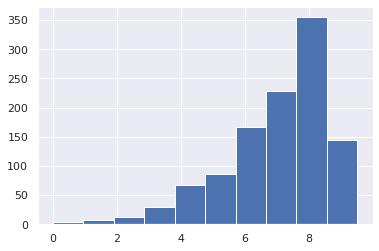

In [61]:
sports['user_score'].hist()

The reason is that sports['user_score']  and action['user_score']  are  not distributed normall
that is why  we have to used Mann-Whitney. 

In [62]:
stat, p = mannwhitneyu(action['user_score'], sports['user_score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print("We can't reject the null hypothesis")
else:
	print("We reject the null hypothesis")

Statistics=3489172.500, p=0.000
We reject the null hypothesis


The seceond  hypothesis is that "Average user ratings for the Action and Sports genres are different."". I take H 0 as the Average user ratings for the Action and Sports genres are (NOT different) the same . ( I took this as Ho beacuse , it is easy to work in this way ) H1 as Average user ratings of the Xbox One and PC platforms differs. I order to find answers to these questions we have to look at the Average user ratings of both find means, and the probability that both have the same value, if the p-value is less than 0.05 we reject H0 otherwise we will accept H0. The distribution of monthly income is nonparametric therefore, I used Mann Whitney U test. 

Average user ratings for the Action and Sports genres are different

### Step 6. Write a general conclusion


The data has a lot of missing values , therefore , I would say that an c concution from this data would not be so strong , however I tried my best to get overall tendency in the data .I think that the main findigs are sales amount from 1980 to 2016 . Some platform boomed and after a while their disappered from the market . This period could help us to undersand the market , a even we can look at the years the platform boom and fade to find out what they did right or wrong and what maket is demanding , I would say that  the sales over the  regious does not  differe significantly , except the some deviation . North America and Europe are most profitable reason in comprison with others region  in the data , I think this is due to just pupulation , but of course the wealth also play the key role ,it depends on which areas are you compareing. Gernally, ps serios are succesful,  x360  and ps can can meet the  requirement the modern market . I think it is not supprasing that people like action games . The the critics score is not important at all for buyers . By the way , ps2 , x360 , ps3 , wii  and ds are the big platform in all over the world , and action , sports , shooter , role playing  are big genres. Generall, The players play games which benongs to E, T, M ESRB rating.  we used 2 hypothesis to understand the data better ,  the result is that the user score ps and cbox are not the same, and also user score from action